# AI2-Cat Calculation Notebook
此 Notebook 将演示如何从一个结构文件出发，借助 `ai2-cat` 所提供的工具构建执行 AIMD, 势函数训练和性质计算的配置文件并执行以得到所需求数据的方法。

1. 提供初始结构，进行AIMD模拟获取获取轨迹文件与相关能量和力等信息 (可选)
2. 收集轨迹中的结构与对应的能量和力转化为机器学习势函数可训练的数据集格式
3. 基于上述的训练数据集训练机器学习势函数
4. 基于上述的机器学习势函数进行分子动力学模拟+增强采样，获取新的结构
5. 基于力误差判据筛选出新的结构
6. 对上述的新结构进行第一性原理计算获取结构对应的能量和力并加入数据集
7. 迭代步骤3-6直至步骤5无法筛选出新的构象
8. 基于最后的机器学习势函数进行分子动力学模拟+增强采样
9. 基于模拟结果计算反应自由能


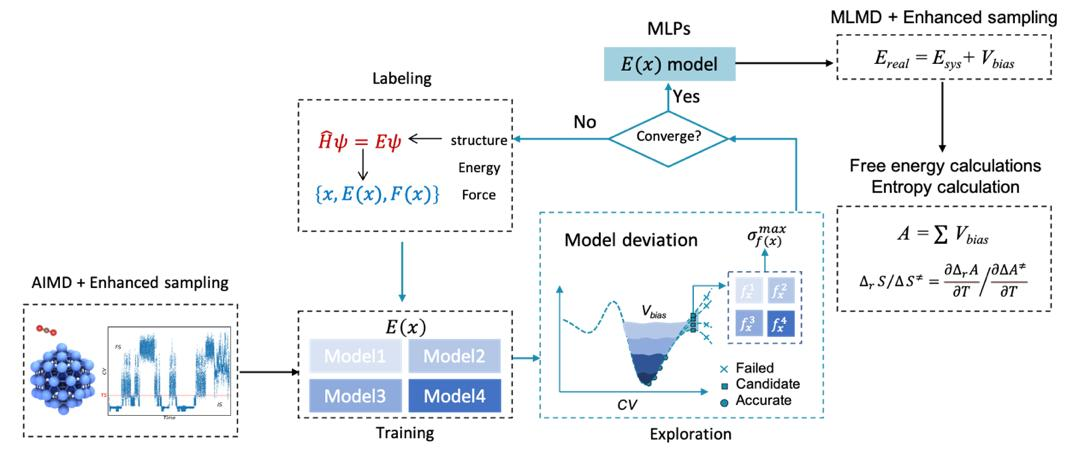

## 准备工作

* [ ] 将此 Notebook 下载到电脑。
* [ ] 在 Open Ondemand 打开的 Jupyter Lab 页面中，通过左边栏上传该文件到工作目录中
* [ ] 打开该 Notebook
* [ ] 将初始结构文件上传到 Notebook 中

上述操作仅在初次或者需要更新 Notebook 时执行即可。

完成 Notebook 上传后，即可按顺序执行各个模块。

In [ ]:
# 每次新打开 notebook 或者重启 kernel 后，该模块均需要执行一次
%matplotlib widget
%gui asyncio

from ai2_kit.feat import catalysis as ai2cat
from ai2_kit.feat.catalysis import ui
import os

AI4EC_DIR              = '/public/groups/ai4ec/data'
CP2K_DATA              = f'{AI4EC_DIR}/cp2k'
CP2K_BATCH_TEMPLATE    = f'{AI4EC_DIR}/slurm/ai2cat-cp2k.sbatch'
LAMMPS_BATCH_TEMPLATE  = f'{AI4EC_DIR}/slurm/ai2cat-lammps.sbatch'
AI2KIT_EXECUTOR_CONFIG = f'{AI4EC_DIR}/ai2-kit/executor.yml'

CP2K_DEFAULTS = dict(
    basic_set_file = os.path.join(CP2K_DATA, 'BASIS_MOLOPT'),
    potential_file = os.path.join(CP2K_DATA, 'GTH_POTENTIALS'),
    parameter_file = os.path.join(CP2K_DATA, 'dftd3.dat'),
)

ui_helper = ui.get_the_ui_helper()
print("Current Directory Is: ", os.getcwd())

## 查看初始结构（可选）
初始结构上传后，可执行以下代码对结构进行可视化。

In [ ]:
from ase.visualize import view
from ase.io import read
from IPython.display import Code, display, Markdown

atoms = read('./POSCAR')  # 可更改此路径以改变要显示的文件
v = view(atoms, viewer='ngl')
v.view.add_ball_and_stick()
display(v)

# AIMD生成初始数据集 (可选)

初始数据集是启动势函数训练的必要输入。如果已经有适用于 DeepMD 的初始数据集和用于 LAMMPS 结构搜索的初始结构，则可以直接上传相应数据直接进入下一步的势函数训练中。

如果没有所需的数据，则可以采用本节所提供的 AIMD 相关功能生成所需的数据。

## 生成 AIMD 配置
计算所需要的结构文件（支持 xyz, cif, POSCAR 等格式) 需自行构建并上传，然后使用以下命令即可生成用于 AIMD 执行的 CP2K 配置。

In [ ]:
! mkdir -p ./00-aimd
ui_helper.gen_aimd_config(out_dir='./00-aimd', **CP2K_DEFAULTS)

此时 `00-aimd` 目录里能找到生成的 CP2K 配置和数据文件。
通过左边栏打开文件可进行检查或编辑。
确认无误后可使用 CP2K 作业模板提交任务。

## 提交 AIMD 作业

In [ ]:
# 复制作业提交脚本到任务目录 (复制后可根据需要进行调整)
! cp {CP2K_BATCH_TEMPLATE} ./00-aimd/cp2k.sbatch

In [ ]:
# 提交作业
! (cd ./00-aimd && sbatch cp2k.sbatch)

In [ ]:
# 检查任务队列
! squeue -u $USER

In [ ]:
# 检查作业执行情况，该命令需要手动停止
! tail -f ./00-aimd/output

## 生成 DeepMD 数据集和 LAMMPS 初始文件

AIMD 作业完成后会在工作目录下生成相应的结构和力数据。通过 `ai2-kit` 所提供的数据格式处理工具可以轻松地将其转换成所需的数据格式。

相关工具的详细使用文档，可见 [ai2-kit ase](https://github.com/chenggroup/ai2-kit/blob/main/doc/manual/ase.md) 和 [ai2-kit dpdata](https://github.com/chenggroup/ai2-kit/blob/main/doc/manual/dpdata.md)

In [ ]:
# 生成初始训练数据集
! ai2-kit tool dpdata read ./00-aimd --fmt cp2kdata/md --cp2k_output_name=output - write ./data/train

In [ ]:
# 生成初始结构
# 以下命令以每 20 帧为间隔从 AIMD 轨迹中抽取结构
# 并限制最大帧数为 20
# 使用 `set_by_ref` 从原始结构文件获取 cell, pbc 等缺失信息
# 然后以 xyz 格式写入指定位置
# 实际使用时可根据实际需求对参数进行调整
! ai2-kit tool ase read ./00-aimd/*-pos-1.xyz --index '::20' - limit 20 - set_by_ref POSCAR - write ./data/explore/init.xyz

# 训练势函数

## 生成 ai2-kit 势函数训练工作流配置

AIMD 作业顺利完成后可从其输出得到轨迹数据。这里可同样借助 `ai2-cat` 自动生成相关配置文件。需要生成的文件包括
1. CP2K 配置文件 cp2k.inp
2. DeepMD 配置文件 deepmd.json
3. plumed 配置文件 plumed.inp
4. ai2-kit cll-mpl-training 配置文件 training.yml 和 executor.yml

配置生成分为两部分，首先执行下面代码生成工作流所依赖的第三方软件的配置，包括数据标注用的CP2K配置和增强采样需要用到的plumed配置，执行成功后将在输出目录内产生 cp2k.inp 和 plumed.inp 两个文件。

In [ ]:
! mkdir -p ./01-train
ui_helper.gen_train_vendors_config(out_dir='./01-train', **CP2K_DEFAULTS)

接下来是生成工作流相关的配置。

> 在工作流配置中使用到的DeepMD训练数据和LAMMPS需要首先注册为 artifacts, 再通过对应的 key 进行引用。
>
> 例如，通过上述命令产生的假设 DeepMD 训练数据位于 ./data/train/Ag13O2, 要使用这笔数据，首先要在配置界面中的 artifacts字段里添加一个新artifact, 其中key可以任意指定（例如 train-data), 并设定 url 为 ./data/train/Ag13O2。设置完成后，即可在 train data 的下拉中选择刚刚配置 train-data 引用该数据。
>
> 同理，LAMMPS 的初始结构也需要通过上述方法添加后使用，假设训练数据位于 ./data/explore/init.xyz，可添加一个key为 explore-data 的 artifact, 并指定 url 为 ./data/explore/init.xyz。除此之外，由于新搜索的结构需要被标记，因此需要额外选择要使用的 CP2K 文件，例如 ./01-train/cp2k.inp, 由于需要使用plumed进行增强采样，因此还需要选择相应的 plumed 配置，例如 ./01-train/plumed.inp



In [ ]:
train_dir = os.path.abspath('./01-train/work_dir')
! mkdir -p  {train_dir}
ui_helper.gen_train_config(out_dir='./01-train', steps=400000)
! ai2-kit tool yaml load {AI2KIT_EXECUTOR_CONFIG} - set_value "executors.ikkem.work_dir" {train_dir} - dump > ./01-train/executor.yml

## 编辑 `ai2-kit` 势函数训练工作流配置
目前由于技术方案的限制，自动生成的配置文件中仍有部分需要人工进行调整，必要改动如下
* `plumed.inp`, plumed 的配置, 需要由用户定义增强采样的反应坐标, 以及其它所需的命令
  * 例如增加 `CV1: DISTANCE ATOMS=14,15`，根据具体的研究目标进行配置
* `training.yml`，需要用户指定使用的数据路径，并在工作流中引用
  * 例如在 `artifacts` 一节中需要配置所需使用的体系等

更具体的配置文档可参考相关 [文档](https://github.com/chenggroup/ai2-kit/blob/main/doc/manual/cll-workflow.zh.md) 和 [配置示例](https://github.com/chenggroup/ai2-kit/tree/main/example/config/cll-mlp-training)。

## 执行 `ai2-kit` 势函数训练工作流

配置确认无误后，即可使用以下命令在后台启动训练。

In [ ]:
project_prefix = 'run-01'  # 请根据项目的工作目录修改
os.system(f"(cd ./01-train && nohup ai2-kit workflow cll-mlp-training *.yml --executor ikkem --path-prefix {project_prefix} --checkpoint {project_prefix}.pickle &> nohup.out&)")

In [ ]:
# 查看日志输出以确定执行是否正常, 注意该命令需要手动退出
! tail -f ./01-train/nohup.out

## 阶段性结果检查
在很多情况下，尤其是针对复杂体系，势函数的训练往往不是一蹴而就。因此，一种比较稳健的策略阶段性地执行工作流，即在训练开始时指定较小的 `max_iter`, 在训练完成后对输出进行检查，并根据结果对配置进行必要的调整 (手动打开配置文件进行更新) 再次执行相同的训练命令，此时工作流会继承先前的状态，继续执行后续的迭代，直到势函数的训练结果满足要求。

以下使用 `ai2-cat` 工具包中提供的工具对结果进行检查。

### 检查 DeepMD 输出
检查势函数训练的力误差与能量误差随训练步数的演化关系，误差的演化应为指数下降的趋势最后在一个相对较小的值附近震荡

In [ ]:
ui_helper.inspect_deepmd_output('./01-train/work_dir')

### 检查 LAMMPS 输出
检查模拟采样过程中，模型最大力偏差随模拟时间的变化关系，在初期几轮采样过程中该模型偏差会较大属于正常现象，迭代到后期模型偏差应大部分落在精确区间内，检查反应坐标随时间的变化关系，当模拟时间较短，反应坐标变化不会太大应在某个特定值（如反应始态或者终态反应坐标所对应的值）附近震荡，当模拟时间较长，反应坐标会出现较大变化（应在反应始态和终态反应坐标所对应的值之间来回震荡）

In [ ]:
ui_helper.inspect_lammps_output('./01-train/work_dir')

# 基于势函数进行动态催化模拟

在得到满足要求的势函数后，即可使用势函数进行动态催化模拟以得到相关性质，并对输出结果进行分析得到报告。

## 配置生成

生成模拟所需lammps以及plumed配置文件，依据反应坐标配置plumed输入文件
* `plumed.dat`, plumed 的配置, 需要由用户定义增强采样的反应坐标, 以及其它所需的命令
  * 例如增加 `CV1: DISTANCE ATOMS=14,15`，根据具体的研究目标进行配置
 
以下命令可以在 生成基本的作业模板，模板生成后可进入 `./02-simluation` 目录对其进行检查和编辑

In [ ]:
ui_helper.gen_lammps_config(out_dir='./02-simulation', work_dir='./01-train/work_dir/')

## 提交作业

In [ ]:
# 复制作业提交脚本到工作目录
! cp {LAMMPS_BATCH_TEMPLATE} ./02-simulation/lammps.sbatch

In [ ]:
# 提交作业
! (cd ./02-simulation/ && sbatch lammps.sbatch)

In [ ]:
# 检查任务队列
! squeue -u $USER

In [ ]:
# 检查实时日志，该命令需要手动停止
! tail -f ./02-simulation/lammps.log

## 生成报告
上述计算完成后，会在目录下生成一个名为 `fes.dat` 的文件，通过以下代码可将其可视化。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fes_data_path = './02-simulation/fes.dat'

cv_fes = np.loadtxt(fes_data_path)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(cv_fes[:,0],cv_fes[:,1],lw=2)
ax.set_xlabel(r'$CV$')
ax.set_ylabel(r'$Free \ energy \ (kJ/mol)$')
ax.set_title(r'$Free \ energy \ curve$');